In [27]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as sk
from sklearn.utils import shuffle
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score

In [28]:
# get input data from Keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# combine x_train and x_test for later pre-processing
X = np.vstack([x_train,x_test])
y = np.append(y_train,y_test)

In [29]:
# split data by categories of 6 and 4 items
# create test2 and training dara
training_images_lab = {0:"top", 1:"trouser", 2:"pullover", 4:"coat", 5:"sandal", 9:"ankle boot"}
unseen_image_lab = {3:"dress", 7:"sneaker", 8:"bag", 6:"shirt"}
X_train = []
y_train = []
X_test = []
y_test = []
for index in range(len(y)):    
    if y[index] in training_images_lab.keys():
        X_train.append(X[index])
        y_train.append(y[index])
    else:
        X_test.append(X[index])
        y_test.append(y[index])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test2 = np.array(X_test)
y_test2 = np.array(y_test)

In [30]:
# split training data into training and test1
X_train, X_test1, y_train, y_test1 = sk.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# union test1 and test2
X_test3, y_test3 = np.concatenate([X_test1, X_test2]), np.concatenate([y_test1, y_test2])

In [31]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    x: image data
    digit_indices: location of data which arrange by categories
    '''
    pairs = []
    labels = []
    # n: minimum pairs that we can create in all category 
    n = min([len(digit_indices[d]) for d in range(len(digit_indices))]) - 1
    for d in range(len(digit_indices)):
        for i in range(n):
            # Postive Pairs
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative Pairs, randomly pick on in other category 
            inc = random.randrange(1, len(digit_indices))
            dn = (d + inc) % len(digit_indices)
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0, 1]
    return np.array(pairs), np.array(labels)

In [32]:
# Training data - 80%
digit_indices = [np.where(y_train == i)[0] for i in list(training_images_lab.keys())]
train_x, train_y = create_pairs(X_train, digit_indices)
# Test 1 - 20% 
digit_indices = [np.where(y_test1 == i)[0] for i in list(training_images_lab.keys())]
test_x1, test_y1 = create_pairs(X_test1, digit_indices)
# Test 2 - 4 categories 
digit_indices = [np.where(y_test2 == i)[0] for i in list(unseen_image_lab.keys())]
test_x2, test_y2 = create_pairs(X_test2, digit_indices)
# Test 3 - Test1 Union Test2
all_images = list(training_images_lab.keys())+list(unseen_image_lab.keys())
digit_indices = [np.where(y_test3 == i)[0] for i in all_images]
test_x3, test_y3 = create_pairs(X_test3, digit_indices)

In [33]:
fig, ax = plt.subplots(nrows=10, ncols=4,figsize=(40, 40))
idx = 0
for row in range(10):
    idx = random.randrange(0,len(train_pairs),2)
    ax[row,0].imshow(train_pairs[idx][0],cmap = 'gray')
    ax[row,1].imshow(train_pairs[idx][1],cmap = 'gray')
    idx+=1
    ax[row,2].imshow(train_pairs[idx][0],cmap = 'gray')
    ax[row,3].imshow(train_pairs[idx][1],cmap = 'gray')
plt.show()

In [34]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [35]:
# Normalize train and test data
train_x = train_x.astype('float32')/255
test_x1 = test_x1.astype('float32')/255
test_x2 = test_x2.astype('float32')/255
test_x3 = test_x3.astype('float32')/255

In [36]:
# Reshape into (n, 2, 28, 28, 1)
# where n is number of examples
# img_rows and img_cols are the size of data
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0], 2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0], 2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0], 2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [37]:
# split training data into train and validation for training
train_x, val_x, train_y, val_y = sk.train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [38]:
def euclidean_distance(vects):
    '''
    compute the euclidean distance between a and b
    which a and b are ouput from two embedding layers
    the representation of embedding is highly dimensional    
    '''
    a, b = vects
    sum_square = K.sum(K.square(a - b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    #return the shape of embedding output
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred, m = 1):
    '''
    y_pred: the distance which computed by eclidean distance
    y_true: ground truth, 1: same category, 0: different category
    m: margin which compute if a pair is in same region

    for a postive pair, we want the embedding presentation points are in a region
    for a negative pair, we want the embedding presentation points are outside the region
    
    the loss function can be split into 2 part:
    Positive pair loss1: D(Pi,Pj)^2 , where y_true = 0
    Negative pair loss2: max(0, m - D(Pi,Pj))^2  , where y_true = 1
    
    Here, we remove 1/2, cuz it's redundant
    '''
    
#   y_ture == 0
    loss1 = tf.cast(K.equal(y_true,0),dtype = 'float32') * K.square(y_pred)
#   y_ture == 1 , K.maximum:  find the element-wise maximum of tensors
    loss2 = tf.cast(K.equal(y_true,1),dtype = 'float32') * K.square(K.maximum(m - y_pred, 0))
    return K.mean(loss1 + loss2)


def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold (0.5) on distance.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [39]:
# create siamese network 
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network will be shared across the two networks
    embedding_a = base_network(input_a)
    embedding_b = base_network(input_b)
    # compute the distance of embadding layer
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [73]:
#Plot loss and accuracy for the model
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Tuning:"+parameter+" loss")
    plt.savefig('./images/'+parameter+'_loss.png', bbox_inches='tight')
    plt.show()
    plt.close()
    
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Tuning :"+parameter+" accuracy")
    plt.savefig('./images/'+parameter+'_accuracy.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [41]:
#Evaluate the model:test accuracy, confusion matrix and ROC curve
def evaluate_test_accuracy_roc(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    # use trained model to predict test data
    # compute corresponding accuracy
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = accuracy_score(test_y1, pred1>0.5)
    te_acc2 = accuracy_score(test_y2, pred2>0.5)
    te_acc3 = accuracy_score(test_y3, pred3>0.5)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')
    
    # analyse precision and recall
    print(classification_report(test_y1,pred1>0.5))
    print(classification_report(test_y2,pred2>0.5))
    
    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(test_y2,pred2>0.5))
    
    
    # plot ROC curve
    fpr_rf1, tpr_rf1, _ = roc_curve(test_y1, pred1)
    fpr_rf2, tpr_rf2, _ = roc_curve(test_y2, pred2)
    fpr_rf3, tpr_rf3, _ = roc_curve(test_y3, pred3)
    
    roc_index1 = roc_auc_score(test_y1, pred1)
    roc_index2 = roc_auc_score(test_y2, pred2)
    roc_index3 = roc_auc_score(test_y3, pred3)  
    
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf1, tpr_rf1, label='test1 {:.3f}'.format(roc_index1))
    plt.plot(fpr_rf2, tpr_rf2, label='test2 {:.3f}'.format(roc_index2))
    plt.plot(fpr_rf3, tpr_rf3, label='test3 {:.3f}'.format(roc_index3))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve '+ model_name)
    plt.legend(loc='best')
    plt.savefig('./images/'+'roc_curve_'+model_name+'.png', bbox_inches='tight')
    plt.show()
    plt.close()

### embedding length 128,64,32,16

In [43]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_128(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [44]:
select_base_arch=create_base_network_leaky_relu_128(input_shape)
model_128=siamese_model(input_shape,select_base_arch)

model_name_128='Leaky_relu_lr_1e-4_embedding_128'
# train
epochs = 800
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_128.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_128 = model_128.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 71us/sample - loss: 0.0441 - accuracy: 0.9515 - val_loss: 0.0393 - val_accuracy: 0.9529
Epoch 35/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0434 - accuracy: 0.9520 - val_loss: 0.0391 - val_accuracy: 0.9547
Epoch 36/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0429 - accuracy: 0.9533 - val_loss: 0.0390 - val_accuracy: 0.9558
Epoch 37/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0425 - accuracy: 0.9540 - val_loss: 0.0384 - val_accuracy: 0.9557
Epoch 38/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0421 - accuracy: 0.9542 - val_loss: 0.0380 - val_accuracy: 0.9550
Epoch 39/800
60145/60145 [==============================] - 5s 77us/sample - loss: 0.0417 - accuracy: 0.9550 - val_loss: 0.0378 - val_accuracy: 0.9567
Epoch 40/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0415 - accuracy: 0.955

60145/60145 [==============================] - 4s 72us/sample - loss: 0.0261 - accuracy: 0.9795 - val_loss: 0.0259 - val_accuracy: 0.9772
Epoch 143/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0258 - accuracy: 0.9805 - val_loss: 0.0260 - val_accuracy: 0.9756
Epoch 144/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0258 - accuracy: 0.9807 - val_loss: 0.0259 - val_accuracy: 0.9777
Epoch 145/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0258 - accuracy: 0.9809 - val_loss: 0.0257 - val_accuracy: 0.9783
Epoch 146/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0257 - accuracy: 0.9803 - val_loss: 0.0257 - val_accuracy: 0.9772
Epoch 147/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0256 - accuracy: 0.9806 - val_loss: 0.0257 - val_accuracy: 0.9793
Epoch 148/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0257 - accuracy:

Epoch 196/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0229 - accuracy: 0.9849 - val_loss: 0.0243 - val_accuracy: 0.9799
Epoch 197/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0231 - accuracy: 0.9845 - val_loss: 0.0240 - val_accuracy: 0.9807
Epoch 198/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0229 - accuracy: 0.9850 - val_loss: 0.0239 - val_accuracy: 0.9807
Epoch 199/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0229 - accuracy: 0.9851 - val_loss: 0.0239 - val_accuracy: 0.9799
Epoch 200/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0230 - accuracy: 0.9852 - val_loss: 0.0238 - val_accuracy: 0.9808
Epoch 201/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0230 - accuracy: 0.9848 - val_loss: 0.0239 - val_accuracy: 0.9798
Epoch 202/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Epoch 250/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0212 - accuracy: 0.9879 - val_loss: 0.0228 - val_accuracy: 0.9811
Epoch 251/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0211 - accuracy: 0.9876 - val_loss: 0.0228 - val_accuracy: 0.9807
Epoch 252/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0211 - accuracy: 0.9874 - val_loss: 0.0231 - val_accuracy: 0.9802
Epoch 253/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0211 - accuracy: 0.9878 - val_loss: 0.0228 - val_accuracy: 0.9807
Epoch 254/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0212 - accuracy: 0.9878 - val_loss: 0.0228 - val_accuracy: 0.9807
Epoch 255/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0210 - accuracy: 0.9880 - val_loss: 0.0228 - val_accuracy: 0.9817
Epoch 256/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Tuning :Leaky_relu_lr_1e-4_embedding_128


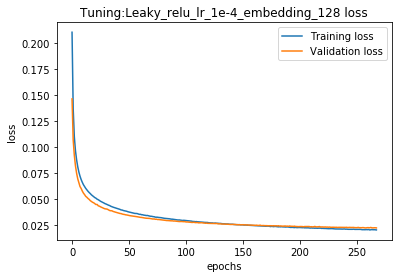

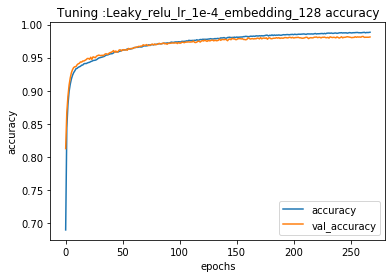

In [94]:
plot_loss_accuracy(history_128, model_name_128)

Tuning :Leaky_relu_lr_1e-4_embedding_128
* Accuracy on test1 set: 97.06%
* Accuracy on test2 set: 70.80%
* Accuracy on test3 set: 84.84%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.96      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.60      0.67     27996
           1       0.67      0.82      0.74     27996

    accuracy                           0.71     55992
   macro avg       0.72      0.71      0.70     55992
weighted avg       0.72      0.71      0.70     55992

Confusion Matrix
[[16815 11181]
 [ 5166 22830]]


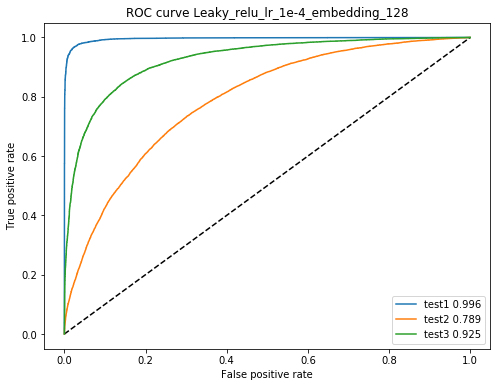

In [95]:
evaluate_test_accuracy_roc(model_128, model_name_128, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [47]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_64(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(64, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [48]:
select_base_arch=create_base_network_leaky_relu_64(input_shape)
model_64=siamese_model(input_shape,select_base_arch)

model_name_64='Leaky_relu_lr_1e-4_embedding_64'
# train
epochs = 800
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_64.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_64 = model_64.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 72us/sample - loss: 0.0338 - accuracy: 0.9670 - val_loss: 0.0311 - val_accuracy: 0.9699
Epoch 89/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0335 - accuracy: 0.9679 - val_loss: 0.0311 - val_accuracy: 0.9692
Epoch 90/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0334 - accuracy: 0.9676 - val_loss: 0.0310 - val_accuracy: 0.9694
Epoch 91/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0332 - accuracy: 0.9685 - val_loss: 0.0310 - val_accuracy: 0.9692
Epoch 92/800
60145/60145 [==============================] - 5s 76us/sample - loss: 0.0332 - accuracy: 0.9680 - val_loss: 0.0311 - val_accuracy: 0.9709
Epoch 93/800
60145/60145 [==============================] - 4s 74us/sample - loss: 0.0330 - accuracy: 0.9692 - val_loss: 0.0309 - val_accuracy: 0.9706
Epoch 94/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0329 - accuracy: 0.969

60145/60145 [==============================] - 4s 71us/sample - loss: 0.0290 - accuracy: 0.9754 - val_loss: 0.0279 - val_accuracy: 0.9738
Epoch 143/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0289 - accuracy: 0.9758 - val_loss: 0.0277 - val_accuracy: 0.9747
Epoch 144/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0289 - accuracy: 0.9759 - val_loss: 0.0280 - val_accuracy: 0.9746
Epoch 145/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0287 - accuracy: 0.9760 - val_loss: 0.0276 - val_accuracy: 0.9745
Epoch 146/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0288 - accuracy: 0.9757 - val_loss: 0.0276 - val_accuracy: 0.9755
Epoch 147/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0286 - accuracy: 0.9765 - val_loss: 0.0277 - val_accuracy: 0.9746
Epoch 148/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0287 - accuracy:

Epoch 196/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0262 - accuracy: 0.9808 - val_loss: 0.0262 - val_accuracy: 0.9769
Epoch 197/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0261 - accuracy: 0.9804 - val_loss: 0.0262 - val_accuracy: 0.9772
Epoch 198/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0260 - accuracy: 0.9810 - val_loss: 0.0260 - val_accuracy: 0.9763
Epoch 199/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0262 - accuracy: 0.9806 - val_loss: 0.0260 - val_accuracy: 0.9768
Epoch 200/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0260 - accuracy: 0.9815 - val_loss: 0.0261 - val_accuracy: 0.9769
Epoch 201/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0259 - accuracy: 0.9810 - val_loss: 0.0261 - val_accuracy: 0.9760
Epoch 202/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Epoch 250/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0245 - accuracy: 0.9840 - val_loss: 0.0249 - val_accuracy: 0.9789
Epoch 251/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0244 - accuracy: 0.9840 - val_loss: 0.0252 - val_accuracy: 0.9790
Epoch 252/800
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0242 - accuracy: 0.9842 - val_loss: 0.0251 - val_accuracy: 0.9789
Epoch 253/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0243 - accuracy: 0.9835 - val_loss: 0.0250 - val_accuracy: 0.9794
Epoch 254/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0242 - accuracy: 0.9843 - val_loss: 0.0252 - val_accuracy: 0.9788
Epoch 255/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0243 - accuracy: 0.9838 - val_loss: 0.0249 - val_accuracy: 0.9795
Epoch 256/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.02

Epoch 304/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0230 - accuracy: 0.9864 - val_loss: 0.0243 - val_accuracy: 0.9801
Epoch 305/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0228 - accuracy: 0.9867 - val_loss: 0.0243 - val_accuracy: 0.9804
Epoch 306/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0229 - accuracy: 0.9858 - val_loss: 0.0244 - val_accuracy: 0.9802
Epoch 307/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0228 - accuracy: 0.9862 - val_loss: 0.0243 - val_accuracy: 0.9793
Epoch 308/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0228 - accuracy: 0.9866 - val_loss: 0.0243 - val_accuracy: 0.9798
Epoch 309/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0227 - accuracy: 0.9868 - val_loss: 0.0242 - val_accuracy: 0.9800
Epoch 310/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Epoch 358/800
60145/60145 [==============================] - 5s 75us/sample - loss: 0.0216 - accuracy: 0.9887 - val_loss: 0.0237 - val_accuracy: 0.9818
Epoch 359/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0217 - accuracy: 0.9885 - val_loss: 0.0237 - val_accuracy: 0.9817
Epoch 360/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0217 - accuracy: 0.9880 - val_loss: 0.0236 - val_accuracy: 0.9813
Epoch 361/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0217 - accuracy: 0.9882 - val_loss: 0.0236 - val_accuracy: 0.9814
Epoch 362/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0216 - accuracy: 0.9886 - val_loss: 0.0236 - val_accuracy: 0.9813
Epoch 363/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0216 - accuracy: 0.9883 - val_loss: 0.0235 - val_accuracy: 0.9816
Epoch 364/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Epoch 412/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0206 - accuracy: 0.9900 - val_loss: 0.0229 - val_accuracy: 0.9811
Epoch 413/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0207 - accuracy: 0.9897 - val_loss: 0.0230 - val_accuracy: 0.9824
Epoch 414/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0207 - accuracy: 0.9900 - val_loss: 0.0229 - val_accuracy: 0.9823
Epoch 415/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0208 - accuracy: 0.9899 - val_loss: 0.0230 - val_accuracy: 0.9813
Epoch 416/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0207 - accuracy: 0.9900 - val_loss: 0.0228 - val_accuracy: 0.9823
Epoch 417/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0207 - accuracy: 0.9900 - val_loss: 0.0229 - val_accuracy: 0.9818
Epoch 418/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.02

Tuning :Leaky_relu_lr_1e-4_embedding_64


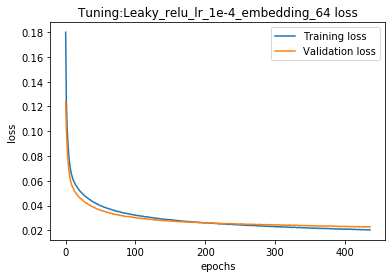

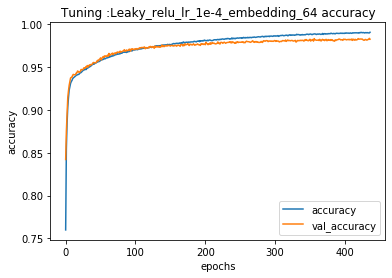

Tuning :Leaky_relu_lr_1e-4_embedding_64
* Accuracy on test1 set: 97.07%
* Accuracy on test2 set: 71.40%
* Accuracy on test3 set: 85.35%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.97      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.63      0.69     27996
           1       0.68      0.80      0.74     27996

    accuracy                           0.71     55992
   macro avg       0.72      0.71      0.71     55992
weighted avg       0.72      0.71      0.71     55992

Confusion Matrix
[[17679 10317]
 [ 5696 22300]]


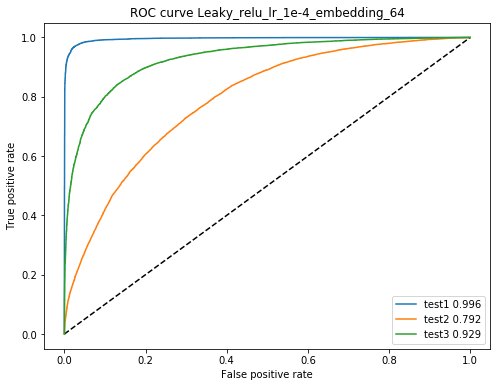

In [96]:
plot_loss_accuracy(history_64, model_name_64)
evaluate_test_accuracy_roc(model_64, model_name_64, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [50]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_32(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(32, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [51]:
select_base_arch=create_base_network_leaky_relu_32(input_shape)
model_32=siamese_model(input_shape,select_base_arch)

model_name_32='Leaky_relu_lr_1e-4_embedding_32'
# train
epochs = 800
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_32.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_32 = model_32.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 72us/sample - loss: 0.0334 - accuracy: 0.9684 - val_loss: 0.0310 - val_accuracy: 0.9681
Epoch 89/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0332 - accuracy: 0.9682 - val_loss: 0.0310 - val_accuracy: 0.9678
Epoch 90/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0331 - accuracy: 0.9682 - val_loss: 0.0308 - val_accuracy: 0.9699
Epoch 91/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0330 - accuracy: 0.9691 - val_loss: 0.0311 - val_accuracy: 0.9700
Epoch 92/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0328 - accuracy: 0.9690 - val_loss: 0.0308 - val_accuracy: 0.9689
Epoch 93/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0326 - accuracy: 0.9695 - val_loss: 0.0307 - val_accuracy: 0.9693
Epoch 94/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0325 - accuracy: 0.969

60145/60145 [==============================] - 4s 73us/sample - loss: 0.0283 - accuracy: 0.9768 - val_loss: 0.0275 - val_accuracy: 0.9732
Epoch 143/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0282 - accuracy: 0.9768 - val_loss: 0.0275 - val_accuracy: 0.9748
Epoch 144/800
60145/60145 [==============================] - 4s 75us/sample - loss: 0.0280 - accuracy: 0.9773 - val_loss: 0.0275 - val_accuracy: 0.9758
Epoch 145/800
60145/60145 [==============================] - 4s 74us/sample - loss: 0.0281 - accuracy: 0.9771 - val_loss: 0.0276 - val_accuracy: 0.9751
Epoch 146/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0280 - accuracy: 0.9774 - val_loss: 0.0274 - val_accuracy: 0.9758
Epoch 147/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0279 - accuracy: 0.9771 - val_loss: 0.0273 - val_accuracy: 0.9748
Epoch 148/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0281 - accuracy:

Epoch 196/800
60145/60145 [==============================] - 4s 74us/sample - loss: 0.0254 - accuracy: 0.9814 - val_loss: 0.0258 - val_accuracy: 0.9776
Epoch 197/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0255 - accuracy: 0.9814 - val_loss: 0.0258 - val_accuracy: 0.9771
Epoch 198/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0253 - accuracy: 0.9816 - val_loss: 0.0258 - val_accuracy: 0.9777
Epoch 199/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0253 - accuracy: 0.9816 - val_loss: 0.0257 - val_accuracy: 0.9777
Epoch 200/800
60145/60145 [==============================] - 4s 75us/sample - loss: 0.0254 - accuracy: 0.9813 - val_loss: 0.0258 - val_accuracy: 0.9795
Epoch 201/800
60145/60145 [==============================] - 4s 73us/sample - loss: 0.0252 - accuracy: 0.9823 - val_loss: 0.0257 - val_accuracy: 0.9777
Epoch 202/800
60145/60145 [==============================] - 4s 74us/sample - loss: 0.02

Epoch 250/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0236 - accuracy: 0.9847 - val_loss: 0.0248 - val_accuracy: 0.9795
Epoch 251/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0236 - accuracy: 0.9847 - val_loss: 0.0249 - val_accuracy: 0.9803
Epoch 252/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0236 - accuracy: 0.9846 - val_loss: 0.0246 - val_accuracy: 0.9796
Epoch 253/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0235 - accuracy: 0.9853 - val_loss: 0.0247 - val_accuracy: 0.9792
Epoch 254/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0234 - accuracy: 0.9853 - val_loss: 0.0247 - val_accuracy: 0.9786
Epoch 255/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0235 - accuracy: 0.9850 - val_loss: 0.0247 - val_accuracy: 0.9799
Epoch 256/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Epoch 304/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0222 - accuracy: 0.9866 - val_loss: 0.0240 - val_accuracy: 0.9803
Epoch 305/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0221 - accuracy: 0.9869 - val_loss: 0.0240 - val_accuracy: 0.9809
Epoch 306/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0221 - accuracy: 0.9873 - val_loss: 0.0239 - val_accuracy: 0.9793
Epoch 307/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0220 - accuracy: 0.9870 - val_loss: 0.0239 - val_accuracy: 0.9800
Epoch 308/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0220 - accuracy: 0.9869 - val_loss: 0.0239 - val_accuracy: 0.9798
Epoch 309/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0220 - accuracy: 0.9876 - val_loss: 0.0238 - val_accuracy: 0.9801
Epoch 310/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.02

Tuning :Leaky_relu_lr_1e-4_embedding_32


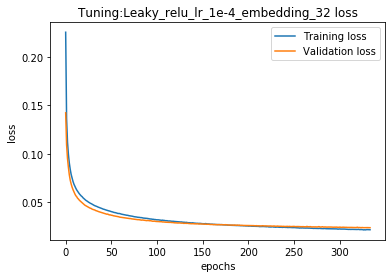

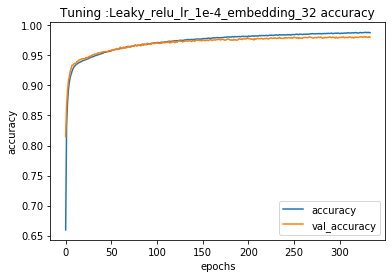

Tuning :Leaky_relu_lr_1e-4_embedding_32
* Accuracy on test1 set: 97.02%
* Accuracy on test2 set: 70.33%
* Accuracy on test3 set: 85.04%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.96      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.75      0.61      0.67     27996
           1       0.67      0.79      0.73     27996

    accuracy                           0.70     55992
   macro avg       0.71      0.70      0.70     55992
weighted avg       0.71      0.70      0.70     55992

Confusion Matrix
[[17196 10800]
 [ 5815 22181]]


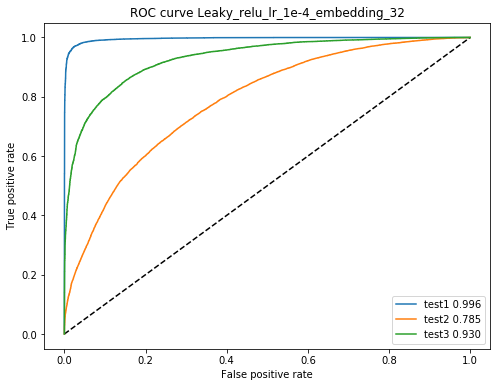

In [97]:
plot_loss_accuracy(history_32, model_name_32)
evaluate_test_accuracy_roc(model_32, model_name_32, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [53]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_16(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(16, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [54]:
select_base_arch=create_base_network_leaky_relu_16(input_shape)
model_16=siamese_model(input_shape,select_base_arch)

model_name_16='Leaky_relu_lr_1e-4_embedding_16'
# train
epochs = 800
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_16.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_16 = model_16.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 72us/sample - loss: 0.0341 - accuracy: 0.9674 - val_loss: 0.0314 - val_accuracy: 0.9694
Epoch 89/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0340 - accuracy: 0.9670 - val_loss: 0.0315 - val_accuracy: 0.9703
Epoch 90/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0339 - accuracy: 0.9674 - val_loss: 0.0312 - val_accuracy: 0.9696
Epoch 91/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0337 - accuracy: 0.9676 - val_loss: 0.0311 - val_accuracy: 0.9690
Epoch 92/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0336 - accuracy: 0.9677 - val_loss: 0.0310 - val_accuracy: 0.9705
Epoch 93/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0335 - accuracy: 0.9676 - val_loss: 0.0310 - val_accuracy: 0.9702
Epoch 94/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0334 - accuracy: 0.968

60145/60145 [==============================] - 4s 71us/sample - loss: 0.0295 - accuracy: 0.9742 - val_loss: 0.0281 - val_accuracy: 0.9745
Epoch 143/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0292 - accuracy: 0.9746 - val_loss: 0.0280 - val_accuracy: 0.9747
Epoch 144/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0291 - accuracy: 0.9748 - val_loss: 0.0280 - val_accuracy: 0.9752
Epoch 145/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0291 - accuracy: 0.9749 - val_loss: 0.0280 - val_accuracy: 0.9737
Epoch 146/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0291 - accuracy: 0.9747 - val_loss: 0.0280 - val_accuracy: 0.9738
Epoch 147/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0290 - accuracy: 0.9752 - val_loss: 0.0280 - val_accuracy: 0.9740
Epoch 148/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.0289 - accuracy:

Epoch 196/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0267 - accuracy: 0.9794 - val_loss: 0.0263 - val_accuracy: 0.9776
Epoch 197/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0264 - accuracy: 0.9794 - val_loss: 0.0263 - val_accuracy: 0.9776
Epoch 198/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0266 - accuracy: 0.9787 - val_loss: 0.0263 - val_accuracy: 0.9769
Epoch 199/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0265 - accuracy: 0.9789 - val_loss: 0.0262 - val_accuracy: 0.9785
Epoch 200/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0265 - accuracy: 0.9788 - val_loss: 0.0261 - val_accuracy: 0.9776
Epoch 201/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0263 - accuracy: 0.9792 - val_loss: 0.0262 - val_accuracy: 0.9774
Epoch 202/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.02

Epoch 250/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0247 - accuracy: 0.9825 - val_loss: 0.0251 - val_accuracy: 0.9796
Epoch 251/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0245 - accuracy: 0.9826 - val_loss: 0.0252 - val_accuracy: 0.9786
Epoch 252/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0246 - accuracy: 0.9822 - val_loss: 0.0251 - val_accuracy: 0.9802
Epoch 253/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0244 - accuracy: 0.9831 - val_loss: 0.0250 - val_accuracy: 0.9791
Epoch 254/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0245 - accuracy: 0.9826 - val_loss: 0.0251 - val_accuracy: 0.9787
Epoch 255/800
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0244 - accuracy: 0.9828 - val_loss: 0.0250 - val_accuracy: 0.9779
Epoch 256/800
60145/60145 [==============================] - 4s 72us/sample - loss: 0.02

Tuning :Leaky_relu_lr_1e-4_embedding_16


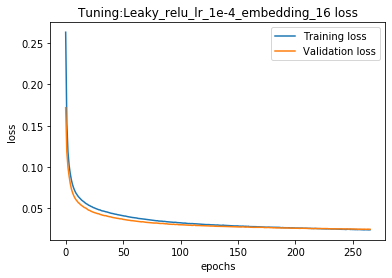

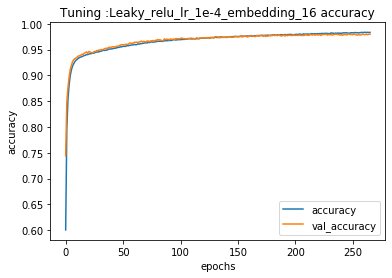

Tuning :Leaky_relu_lr_1e-4_embedding_16
* Accuracy on test1 set: 96.91%
* Accuracy on test2 set: 70.62%
* Accuracy on test3 set: 85.03%
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8238
           1       0.96      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.74      0.63      0.68     27996
           1       0.68      0.78      0.73     27996

    accuracy                           0.71     55992
   macro avg       0.71      0.71      0.70     55992
weighted avg       0.71      0.71      0.70     55992

Confusion Matrix
[[17651 10345]
 [ 6106 21890]]


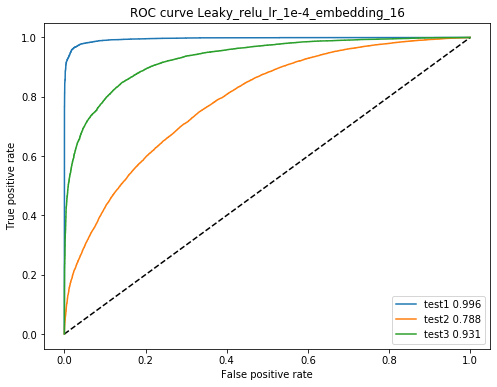

In [98]:
plot_loss_accuracy(history_16, model_name_16)
evaluate_test_accuracy_roc(model_16, model_name_16, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
#confusion matrix plot

In [85]:
#Evaluate the model:test accuracy, confusion matrix and ROC curve
def conf_matrix(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    # use trained model to predict test data
    # compute corresponding accuracy
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = accuracy_score(test_y1, pred1>0.5)
    te_acc2 = accuracy_score(test_y2, pred2>0.5)
    te_acc3 = accuracy_score(test_y3, pred3>0.5)

    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(test_y1,pred1>0.5))
    print(confusion_matrix(test_y2,pred2>0.5))
    print(confusion_matrix(test_y3,pred3>0.5))
    
    return pred1,pred2,pred3

In [86]:
pred1,pred2,pred3=conf_matrix(model_64, model_name_64, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :Leaky_relu_lr_1e-4_embedding_64
Confusion Matrix
[[7949  289]
 [ 193 8045]]
[[17679 10317]
 [ 5696 22300]]
[[11454  2276]
 [ 1746 11984]]


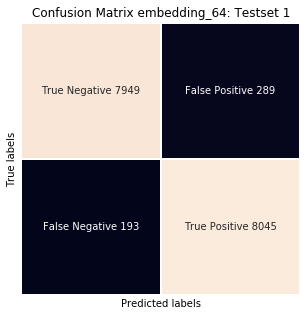

In [87]:
cm=confusion_matrix(test_y1,pred1>0.5)
text = np.asarray([['True Negative', 'False Positive'], ['False Negative' ,'True Positive']])
labels = (np.asarray(["{0} {1:.0f}".format(text,cm) for text, cm in zip(text.flatten(), cm.flatten())])).reshape(2,2)

fig, ax = plt.subplots(figsize=(5, 5))
heat_map = sns.heatmap(cm, annot=labels, fmt='',cbar=False, linewidths=1)
ax.set(yticks=[0, 2], 
       yticklabels=['TN', 'FP'])
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.xticks([])
plt.yticks([])
ax.set_title('Confusion Matrix embedding_64: Testset 1')

plt.savefig('./images/'+'confusion_matrix_Testset1_'+model_name_64+'.png', bbox_inches='tight')
plt.show()
plt.close()

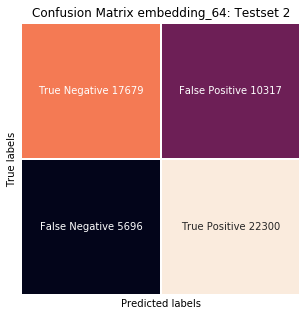

In [93]:
cm=confusion_matrix(test_y2,pred2>0.5)
text = np.asarray([['True Negative', 'False Positive'], ['False Negative' ,'True Positive']])
labels = (np.asarray(["{0} {1:.0f}".format(text,cm) for text, cm in zip(text.flatten(), cm.flatten())])).reshape(2,2)

fig, ax = plt.subplots(figsize=(5, 5))
heat_map = sns.heatmap(cm, annot=labels, fmt='',cbar=False, linewidths=1)
ax.set(yticks=[0, 2], 
       yticklabels=['TN', 'FP'])
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.xticks([])
plt.yticks([])
ax.set_title('Confusion Matrix embedding_64: Testset 2')

plt.savefig('./images/'+'confusion_matrix_Testset2_'+model_name_64+'.png', bbox_inches='tight')
plt.show()
plt.close()

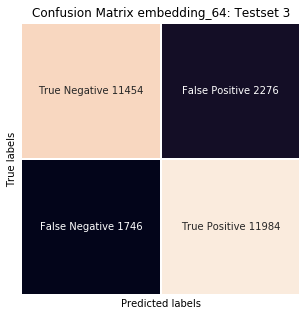

In [88]:
cm=confusion_matrix(test_y3,pred3>0.5)
text = np.asarray([['True Negative', 'False Positive'], ['False Negative' ,'True Positive']])
labels = (np.asarray(["{0} {1:.0f}".format(text,cm) for text, cm in zip(text.flatten(), cm.flatten())])).reshape(2,2)

fig, ax = plt.subplots(figsize=(5, 5))
heat_map = sns.heatmap(cm, annot=labels, fmt='',cbar=False, linewidths=1)
ax.set(yticks=[0, 2], 
       yticklabels=['TN', 'FP'])
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.xticks([])
plt.yticks([])
ax.set_title('Confusion Matrix embedding_64: Testset 3')

plt.savefig('./images/'+'confusion_matrix_Testset3_'+model_name_64+'.png', bbox_inches='tight')
plt.show()
plt.close()